In [ ]:
# Import library
from __future__ import absolute_import,division,print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import os
from os import listdir
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D,Conv2DTranspose,Reshape
from keras.models import Sequential
from keras.layers import LeakyReLU, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model, to_categorical

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint

# !pip install tensorflow-addons==0.8.3
# !pip install tensorflow==2.2.0-rc3

import tensorflow as tf
# import tensorflow_addons as tfa

import tensorflow.keras.layers as layers
import time
from IPython import display

# Install dependency untuk cropping gambar
!pip install imutils
import imutils

# for mathematical operations
import random
import math
# for visualizations
import seaborn as sns
# for image related operations
import PIL
import time
# for warnings
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
warnings.filterwarnings("ignore")

from PIL import Image, ImageChops

# from keras.applications.resnet import ResNet50
# from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow import keras
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dataset dari google drive
file_path = "/content/drive/MyDrive/Brain Tumor Classification System/brain_tumor_dataset"
file_path

'/content/drive/MyDrive/Brain Tumor Classification System/brain_tumor_dataset'

In [ ]:
def load_data_train(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = Image.open(directory + '/' + filename).convert('RGB')
            image = np.array(image)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            X.append(image)

            # Jika direktori asal memiliki nama 'yes' maka akan diberi label 1,
            # Jika bukan maka diberi label 0
            if(directory[-3:] == 'yes'):
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
train_yes = "/content/drive/MyDrive/Data split skripsi/train_data/yes"
train_no = "/content/drive/MyDrive/Data split skripsi/train_data/no"
generated_yes_1 = "/content/drive/MyDrive/Data split skripsi/50/generated_data_1/yes"
generated_no_1 = "/content/drive/MyDrive/Data split skripsi/50/generated_data_1/no"
generated_yes_2 = "/content/drive/MyDrive/Data split skripsi/generated_data_2/yes"
generated_no_2 = "/content/drive/MyDrive/Data split skripsi/generated_data_2/no"
generated_yes_3 = "/content/drive/MyDrive/Data split skripsi/generated_data_3/yes"
generated_no_3 = "/content/drive/MyDrive/Data split skripsi/generated_data_3/no"
test_yes = "/content/drive/MyDrive/Data split skripsi/test_data/yes"
test_no = "/content/drive/MyDrive/Data split skripsi/test_data/no"
val_yes = "/content/drive/MyDrive/Data split skripsi/val_data/yes"
val_no = "/content/drive/MyDrive/Data split skripsi/val_data/no"

IMG_WIDTH, IMG_HEIGHT = (256, 256)

# X, y = load_data_train([train_yes, train_no, test_yes, test_no, val_yes, val_no], (IMG_WIDTH, IMG_HEIGHT))

# X_train, y_train = load_data_train([train_yes, train_no], (IMG_WIDTH, IMG_HEIGHT))
X_train, y_train = load_data_train([train_yes, train_no, generated_yes_1, generated_no_1], (IMG_WIDTH, IMG_HEIGHT))
X_test, y_test = load_data_train([test_yes, test_no], (IMG_WIDTH, IMG_HEIGHT))
X_val, y_val = load_data_train([val_yes, val_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 354
X shape is: (354, 256, 256, 3)
y shape is: (354, 1)
Number of examples is: 38
X shape is: (38, 256, 256, 3)
y shape is: (38, 1)
Number of examples is: 38
X shape is: (38, 256, 256, 3)
y shape is: (38, 1)


In [ ]:
# Cek jumlah training, validation, dan test sample sebelum augmentasi
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 354
number of validation examples = 38
number of test examples = 38


In [ ]:
train_yes = 0
train_no = 0
test_yes = 0
test_no = 0
val_yes = 0
val_no = 0

for i in range(len(y_train)):
  if y_train[i] == 1:
    train_yes += 1
  else:
    train_no += 1

for i in range(len(y_test)):
  if y_test[i] == 1:
    test_yes += 1
  else:
    test_no += 1

for i in range(len(y_val)):
  if y_val[i] == 1:
    val_yes += 1
  else:
    val_no += 1

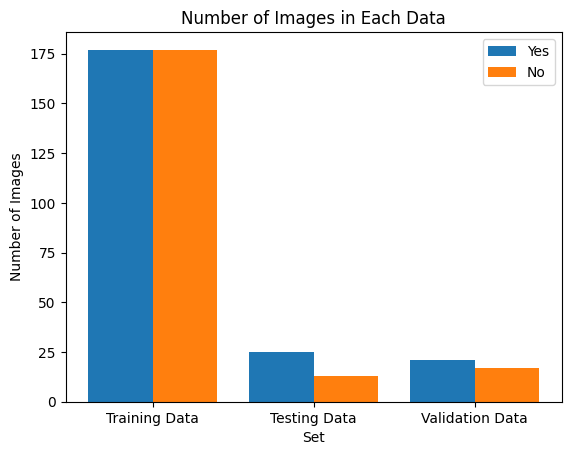

In [ ]:
X = ['Training Data','Testing Data','Validation Data']
yes = [train_yes,test_yes,val_yes]
no = [train_no,test_no,val_no]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, yes, 0.4, label = 'Yes')
plt.bar(X_axis + 0.2, no, 0.4, label = 'No')

plt.xticks(X_axis, X)
plt.xlabel("Set")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Data")
plt.legend()
plt.show()

VGG19

In [ ]:
vgg19_weight_path = '/content/drive/MyDrive/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg19_weight_path

'/content/drive/MyDrive/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
# load base model
base_model = VGG19(
    weights=vgg19_weight_path,
    include_top=False,
    input_shape=(256, 256, 3)
)

In [ ]:
from tensorflow.keras import layers
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)                 32769     
                                                                 
Total params: 20057153 (76.51 MB)
Trainable params: 32769 (128.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=10
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val),
    # callbacks=[es]
)

Epoch 1/5
23/23 [==============================] - 19s 197ms/step - loss: 9.5776 - accuracy: 0.5028 - val_loss: 11.9027 - val_accuracy: 0.5526
Epoch 2/5
23/23 [==============================] - 2s 105ms/step - loss: 4.9411 - accuracy: 0.7119 - val_loss: 6.0793 - val_accuracy: 0.6053
Epoch 3/5
23/23 [==============================] - 2s 101ms/step - loss: 3.3446 - accuracy: 0.7797 - val_loss: 5.4793 - val_accuracy: 0.7368
Epoch 4/5
23/23 [==============================] - 2s 103ms/step - loss: 3.0441 - accuracy: 0.8107 - val_loss: 6.2135 - val_accuracy: 0.5526
Epoch 5/5
23/23 [==============================] - 2s 104ms/step - loss: 2.5794 - accuracy: 0.8559 - val_loss: 6.7933 - val_accuracy: 0.7632


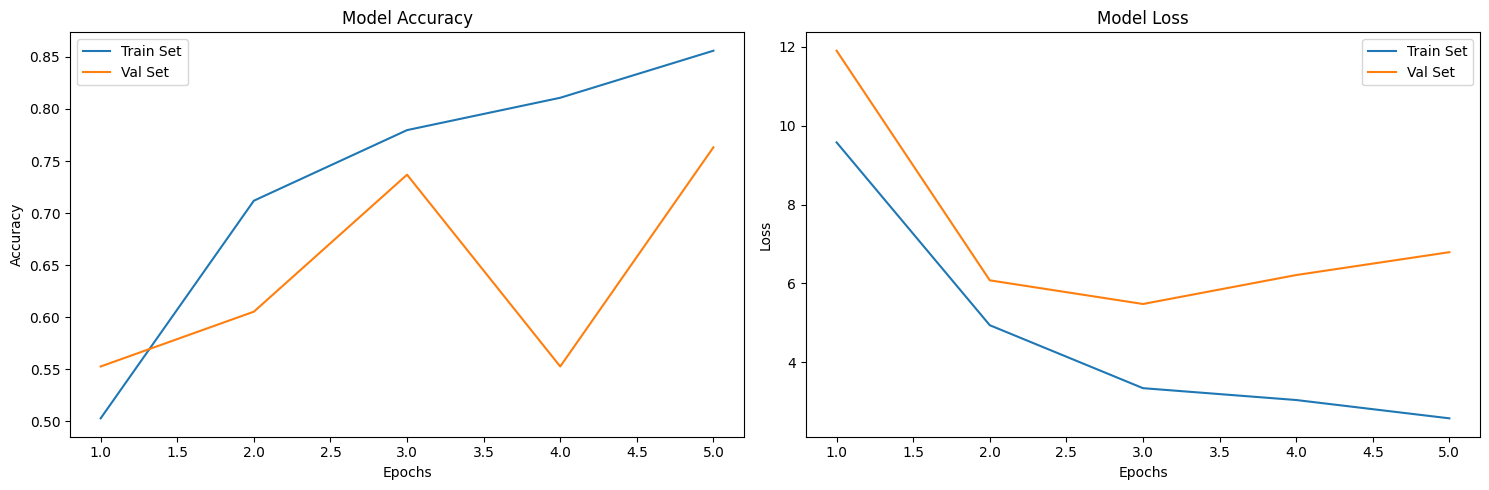

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# NEW
# validate on train set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % (accuracy * 100), '%')

12/12 [==============================] - 5s 160ms/step
Train Accuracy = 92.09 %


In [ ]:
# NEW
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 166ms/step
Val Accuracy = 76.32 %


In [ ]:
# NEW
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 167ms/step
Test Accuracy = 81.58 %


2/2 [==============================] - 0s 168ms/step


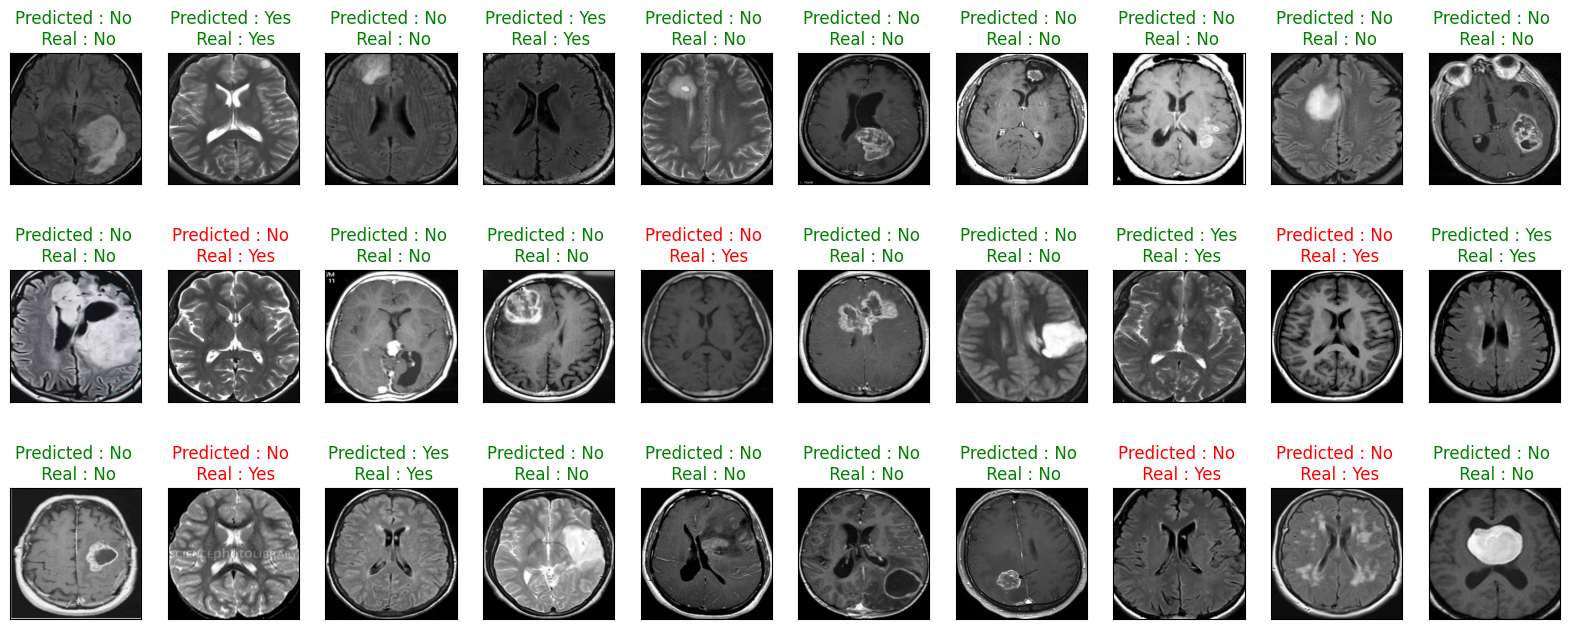

In [ ]:
y_hat = model.predict(X_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Data split skripsi/Model/50_CycleGAN-CNN_16_batch_5_epoch.h5')

BEGIN XGBOOST

In [ ]:
# Export feature from last CNN layer
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_val)
print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

12/12 [==============================] - 2s 177ms/step
(354, 1)
2/2 [==============================] - 0s 157ms/step
(38, 1)
2/2 [==============================] - 0s 166ms/step
(38, 1)


In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(objective='multi:softmax', learning_rate=0.1, max_depth=15, num_class=2)

xb.fit(feat_train,y_train)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(feat_train,y_train)

0.9830508474576272

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data training

# make predictions for train data
y_pred = xb.predict(feat_train)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.31%


In [ ]:
xb.score(feat_val,y_val)

0.7105263157894737

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data validation

# make predictions for val data
y_pred = xb.predict(feat_val)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.05%


Perbandingan akurasi model CNN dan CNN-XGBoost terhadap data testing


In [ ]:
# Akurasi model CNN-VGG19 terhadap data testing

# make predictions for test data
y_pred = model.predict(X_test)

predictions = [np.round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

2/2 [==============================] - 0s 166ms/step
Accuracy: 81.58%


In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data testing

# make predictions for test data
y_pred = xb.predict(feat_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.58%


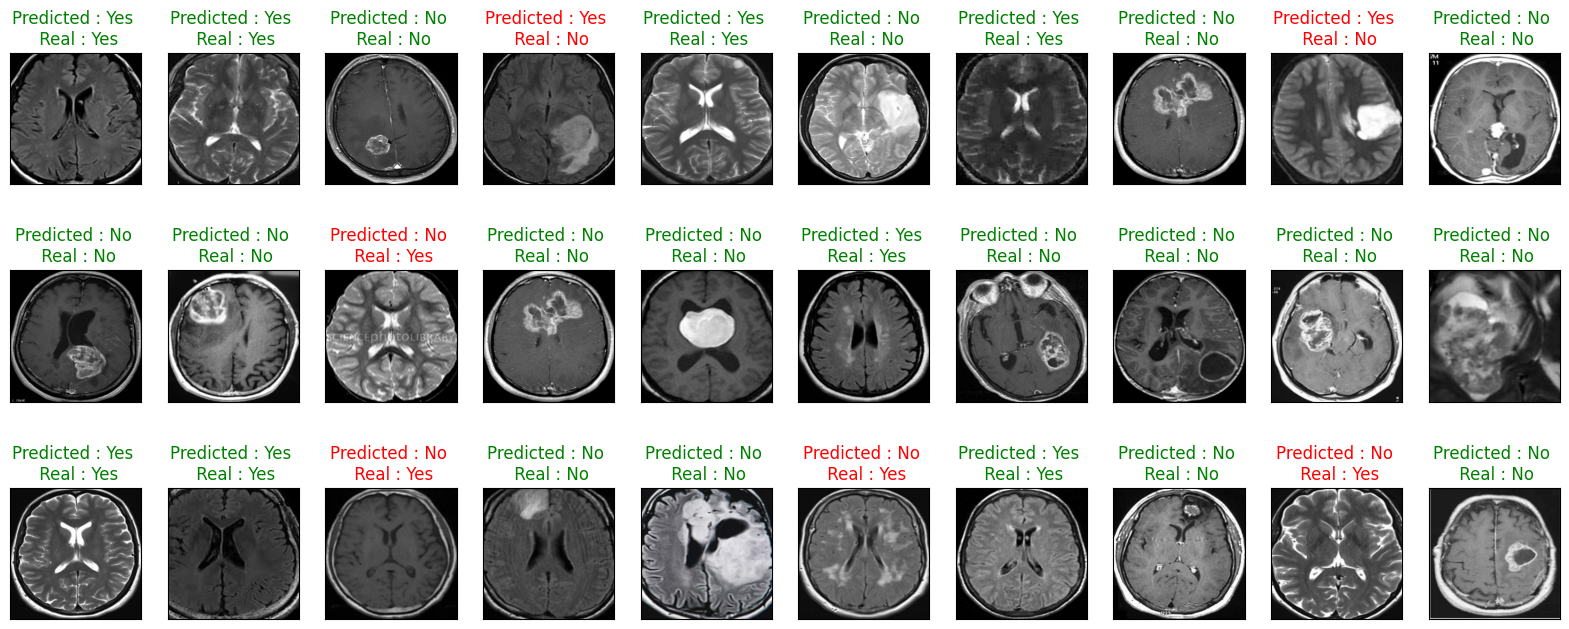

In [ ]:
# NEW
y_hat_xgb = xb.predict(feat_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(feat_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat_xgb[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN-XGBoost_16_batch_5_epoch.h5')

END XGBoost

10 EPOCH

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val),
    # callbacks=[es]
)

Epoch 1/5
23/23 [==============================] - 2s 107ms/step - loss: 1.6705 - accuracy: 0.8785 - val_loss: 6.1259 - val_accuracy: 0.7632
Epoch 2/5
23/23 [==============================] - 2s 107ms/step - loss: 1.5809 - accuracy: 0.8729 - val_loss: 5.5714 - val_accuracy: 0.7105
Epoch 3/5
23/23 [==============================] - 2s 102ms/step - loss: 1.0400 - accuracy: 0.9181 - val_loss: 6.4553 - val_accuracy: 0.7632
Epoch 4/5
23/23 [==============================] - 2s 106ms/step - loss: 0.9907 - accuracy: 0.9096 - val_loss: 6.2532 - val_accuracy: 0.7895
Epoch 5/5
23/23 [==============================] - 3s 112ms/step - loss: 1.6110 - accuracy: 0.8898 - val_loss: 5.8087 - val_accuracy: 0.7105


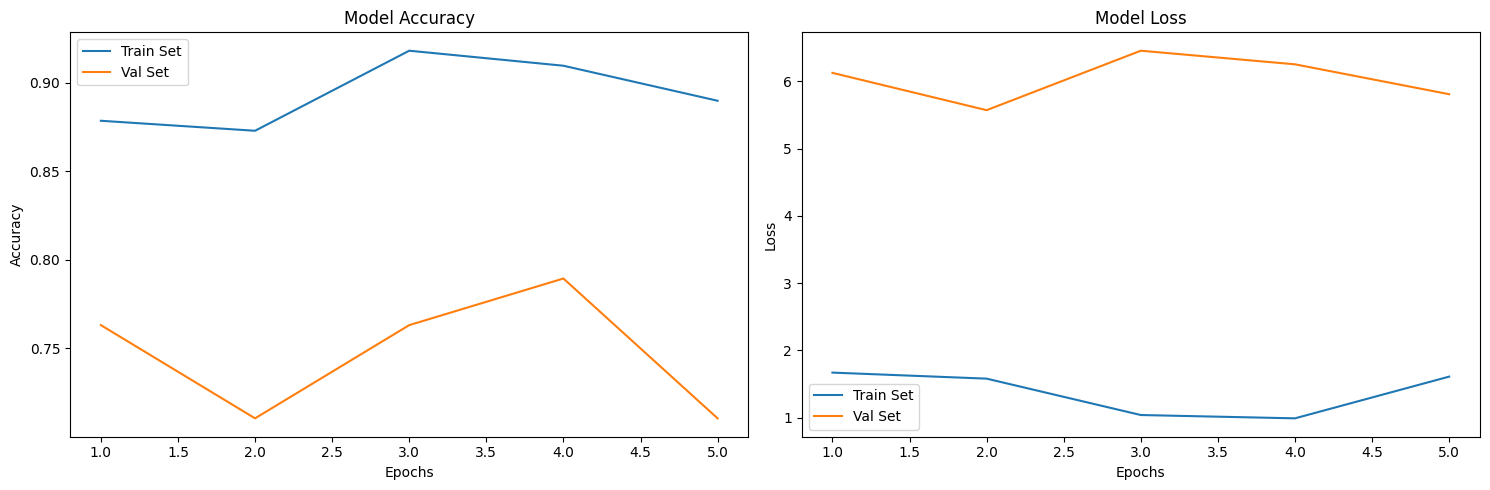

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# NEW
# validate on train set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % (accuracy * 100), '%')

12/12 [==============================] - 2s 184ms/step
Train Accuracy = 96.89 %


In [ ]:
# NEW
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 175ms/step
Val Accuracy = 71.05 %


In [ ]:
# NEW
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 174ms/step
Test Accuracy = 78.95 %


2/2 [==============================] - 0s 184ms/step


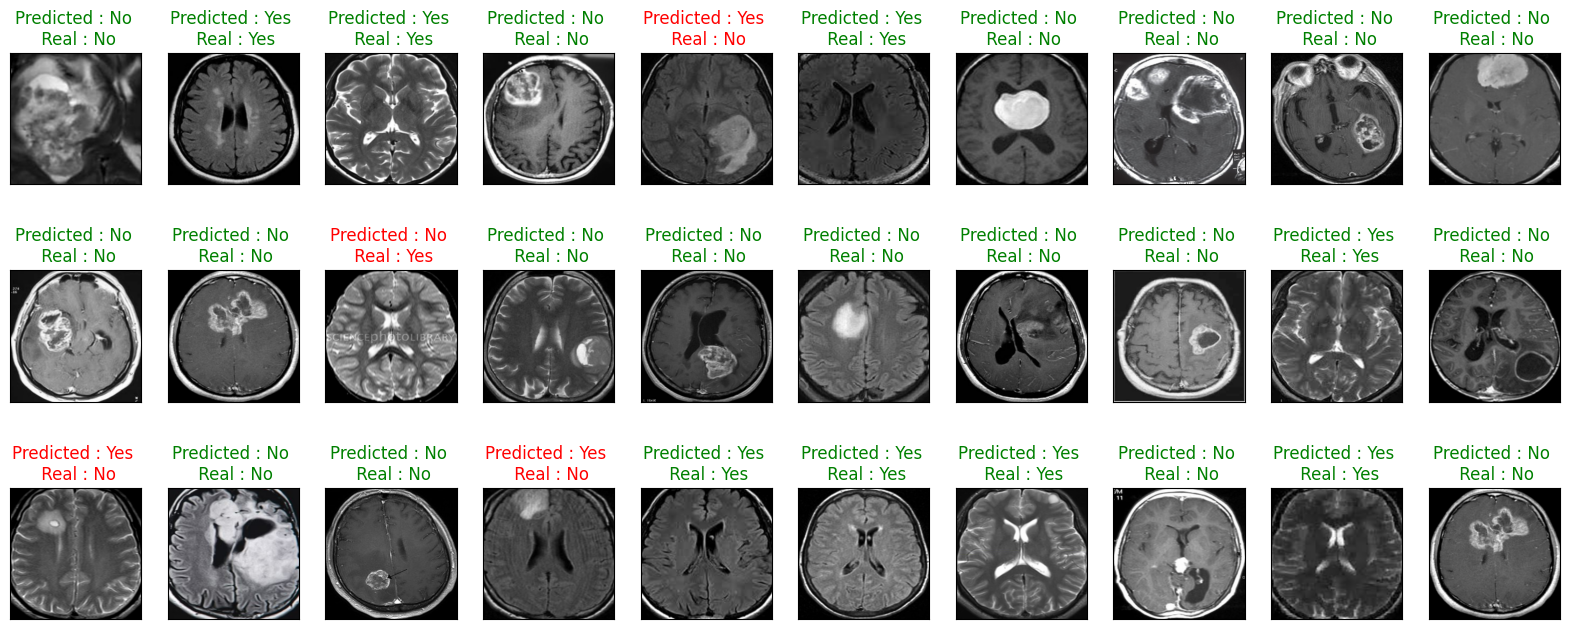

In [ ]:
y_hat = model.predict(X_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN_16_batch_10_epoch.h5')

BEGIN XGBOOST

In [ ]:
# Export feature from last CNN layer
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_val)
print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

12/12 [==============================] - 2s 182ms/step
(354, 1)
2/2 [==============================] - 0s 175ms/step
(38, 1)
2/2 [==============================] - 0s 171ms/step
(38, 1)


In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(objective='multi:softmax', learning_rate=0.1, max_depth=15, num_class=2)

xb.fit(feat_train,y_train)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(feat_train,y_train)

0.9943502824858758

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data training

# make predictions for train data
y_pred = xb.predict(feat_train)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.44%


In [ ]:
xb.score(feat_val,y_val)

0.8157894736842105

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data validation

# make predictions for val data
y_pred = xb.predict(feat_val)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.58%


Perbandingan akurasi model CNN dan CNN-XGBoost terhadap data testing


In [ ]:
# Akurasi model CNN-VGG19 terhadap data testing

# make predictions for test data
y_pred = model.predict(X_test)

predictions = [np.round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

2/2 [==============================] - 0s 173ms/step
Accuracy: 78.95%


In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data testing

# make predictions for test data
y_pred = xb.predict(feat_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.95%


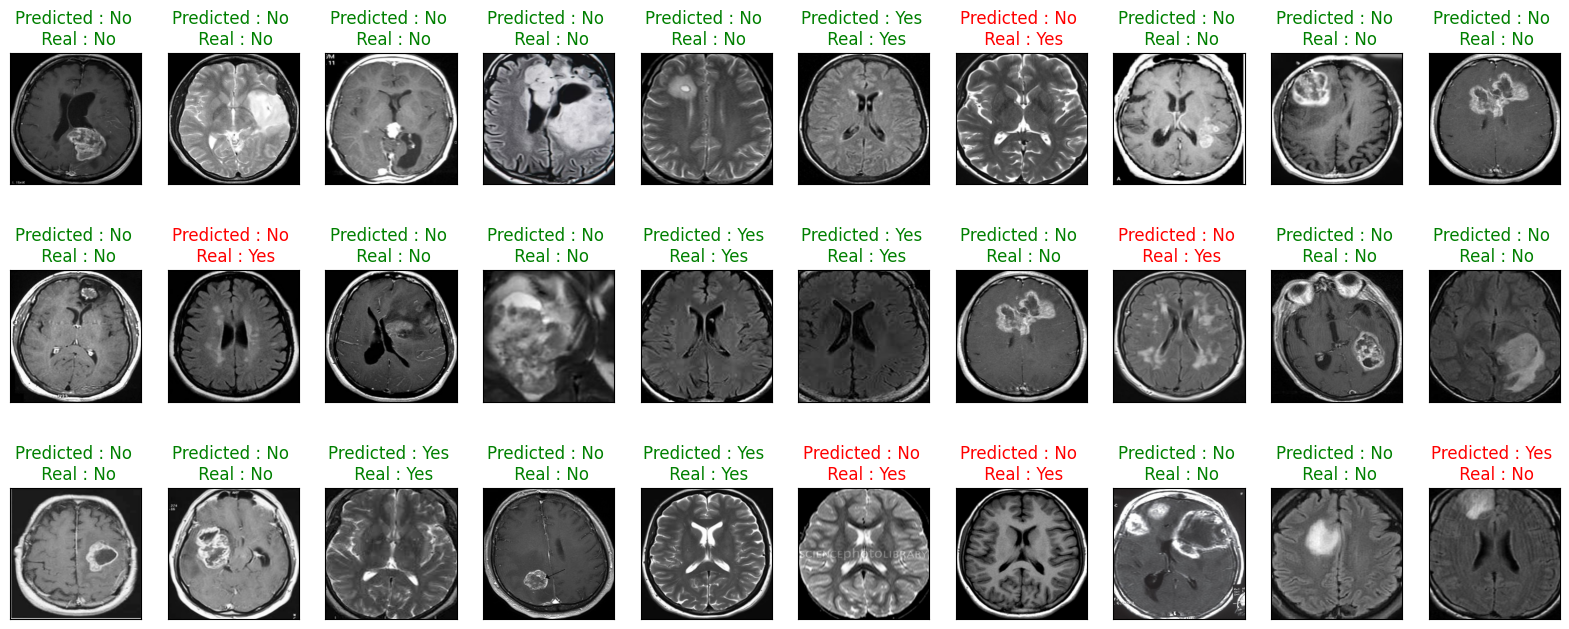

In [ ]:
# NEW
y_hat_xgb = xb.predict(feat_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(feat_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat_xgb[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN-XGBoost_16_batch_10_epoch.h5')

END XGBoost

15 EPOCH

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val),
    # callbacks=[es]
)

Epoch 1/5
23/23 [==============================] - 3s 112ms/step - loss: 1.1120 - accuracy: 0.9237 - val_loss: 5.4575 - val_accuracy: 0.7895
Epoch 2/5
23/23 [==============================] - 2s 108ms/step - loss: 0.7787 - accuracy: 0.9209 - val_loss: 5.8083 - val_accuracy: 0.7368
Epoch 3/5
23/23 [==============================] - 2s 107ms/step - loss: 0.6635 - accuracy: 0.9435 - val_loss: 5.4395 - val_accuracy: 0.7895
Epoch 4/5
23/23 [==============================] - 2s 105ms/step - loss: 0.6059 - accuracy: 0.9463 - val_loss: 7.2129 - val_accuracy: 0.7895
Epoch 5/5
23/23 [==============================] - 2s 109ms/step - loss: 0.6501 - accuracy: 0.9463 - val_loss: 6.8595 - val_accuracy: 0.7632


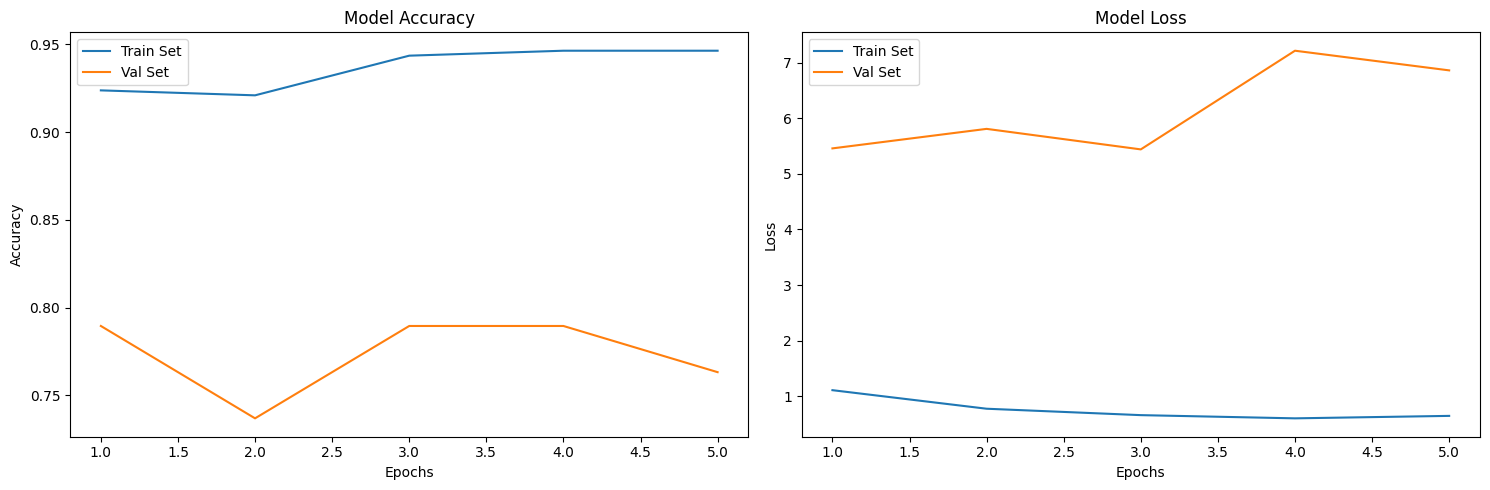

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# NEW
# validate on train set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % (accuracy * 100), '%')

12/12 [==============================] - 2s 191ms/step
Train Accuracy = 98.87 %


In [ ]:
# NEW
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 176ms/step
Val Accuracy = 76.32 %


In [ ]:
# NEW
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 176ms/step
Test Accuracy = 84.21 %


2/2 [==============================] - 0s 178ms/step


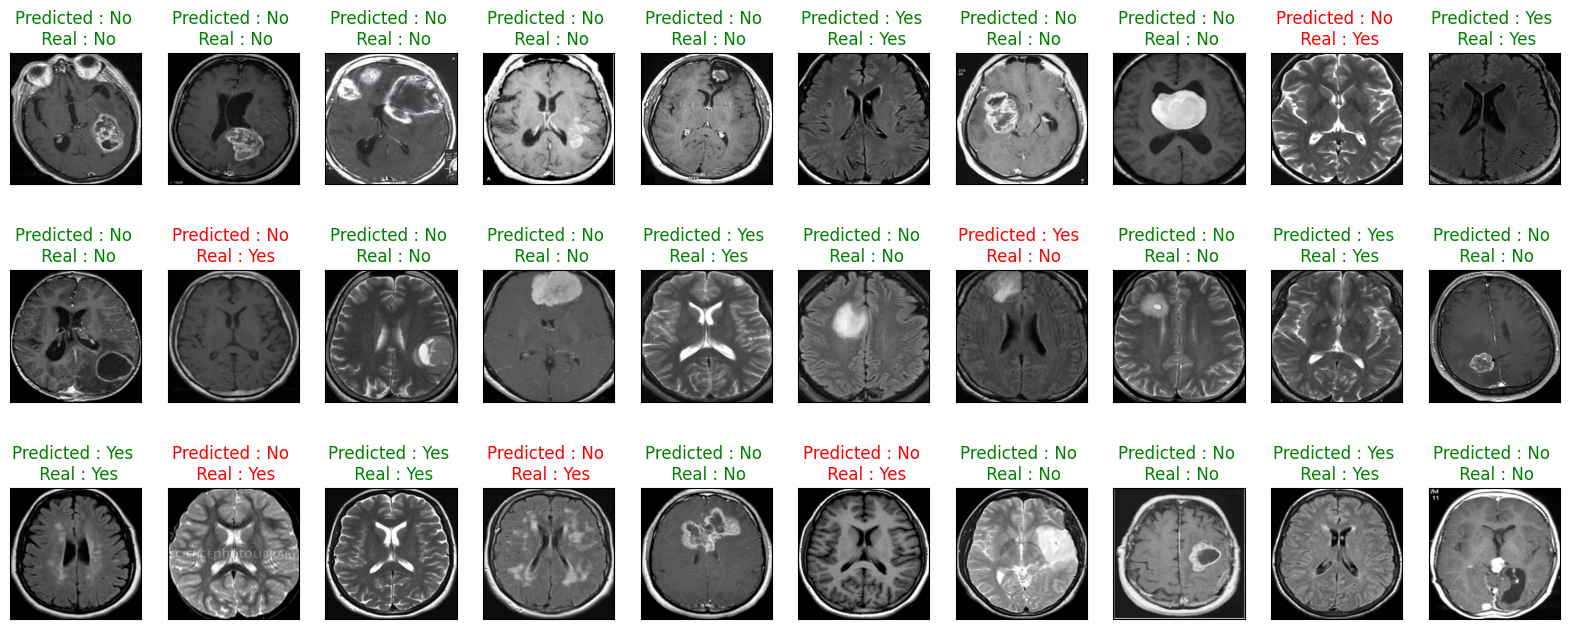

In [ ]:
y_hat = model.predict(X_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN_16_batch_15_epoch.h5')

BEGIN XGBOOST

In [ ]:
# Export feature from last CNN layer
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_val)
print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

12/12 [==============================] - 2s 190ms/step
(354, 1)
2/2 [==============================] - 0s 177ms/step
(38, 1)
2/2 [==============================] - 0s 176ms/step
(38, 1)


In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(objective='multi:softmax', learning_rate=0.1, max_depth=15, num_class=2)

xb.fit(feat_train,y_train)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(feat_train,y_train)

0.9943502824858758

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data training

# make predictions for train data
y_pred = xb.predict(feat_train)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.44%


In [ ]:
xb.score(feat_val,y_val)

0.7631578947368421

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data validation

# make predictions for val data
y_pred = xb.predict(feat_val)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.32%


Perbandingan akurasi model CNN dan CNN-XGBoost terhadap data testing


In [ ]:
# Akurasi model CNN-VGG19 terhadap data testing

# make predictions for test data
y_pred = model.predict(X_test)

predictions = [np.round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

2/2 [==============================] - 0s 178ms/step
Accuracy: 84.21%


In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data testing

# make predictions for test data
y_pred = xb.predict(feat_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.21%


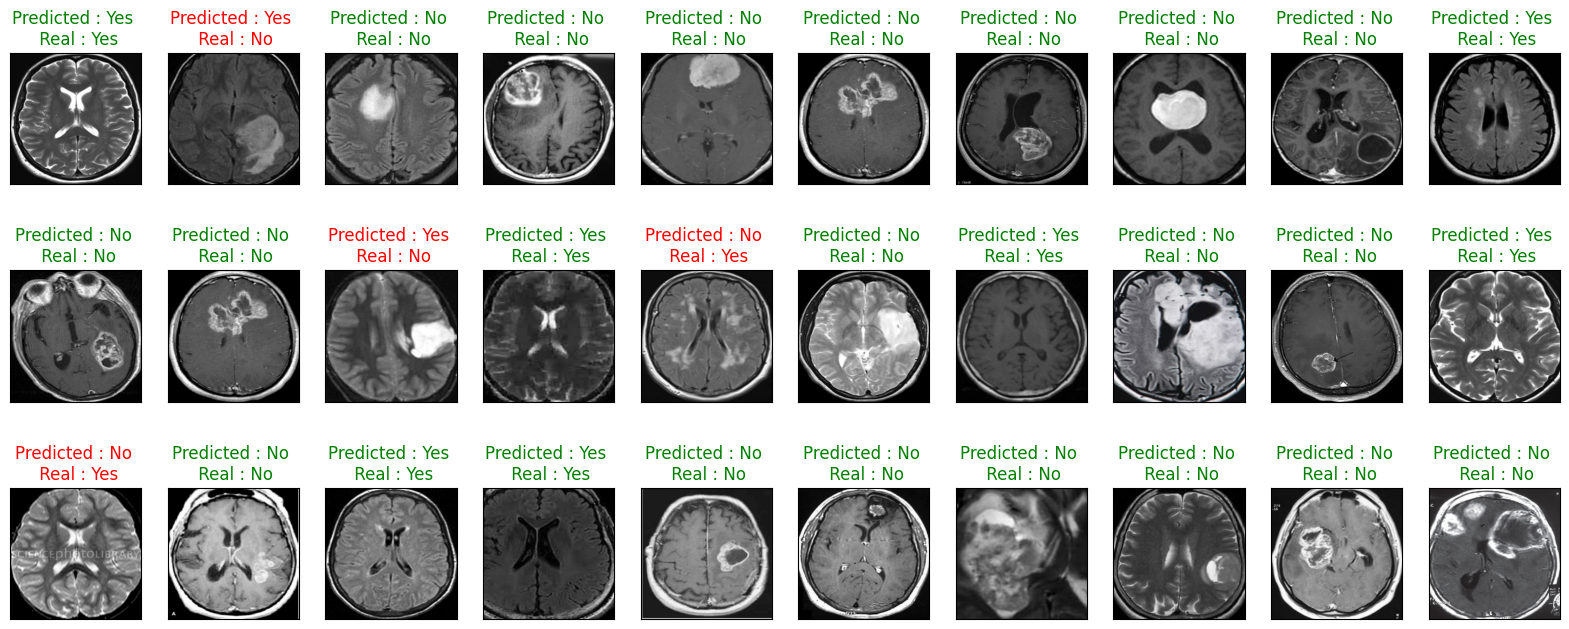

In [ ]:
# NEW
y_hat_xgb = xb.predict(feat_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(feat_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat_xgb[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN-XGBoost_16_batch_15_epoch.h5')

END XGBoost

 20 EPOCH

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val),
    # callbacks=[es]
)

Epoch 1/5
23/23 [==============================] - 3s 112ms/step - loss: 0.5601 - accuracy: 0.9520 - val_loss: 6.7448 - val_accuracy: 0.7368
Epoch 2/5
23/23 [==============================] - 3s 111ms/step - loss: 0.3743 - accuracy: 0.9689 - val_loss: 5.6308 - val_accuracy: 0.7368
Epoch 3/5
23/23 [==============================] - 2s 109ms/step - loss: 0.3908 - accuracy: 0.9605 - val_loss: 6.9058 - val_accuracy: 0.7895
Epoch 4/5
23/23 [==============================] - 3s 113ms/step - loss: 0.6401 - accuracy: 0.9520 - val_loss: 8.5956 - val_accuracy: 0.7368
Epoch 5/5
23/23 [==============================] - 3s 113ms/step - loss: 0.6430 - accuracy: 0.9407 - val_loss: 7.7840 - val_accuracy: 0.7368


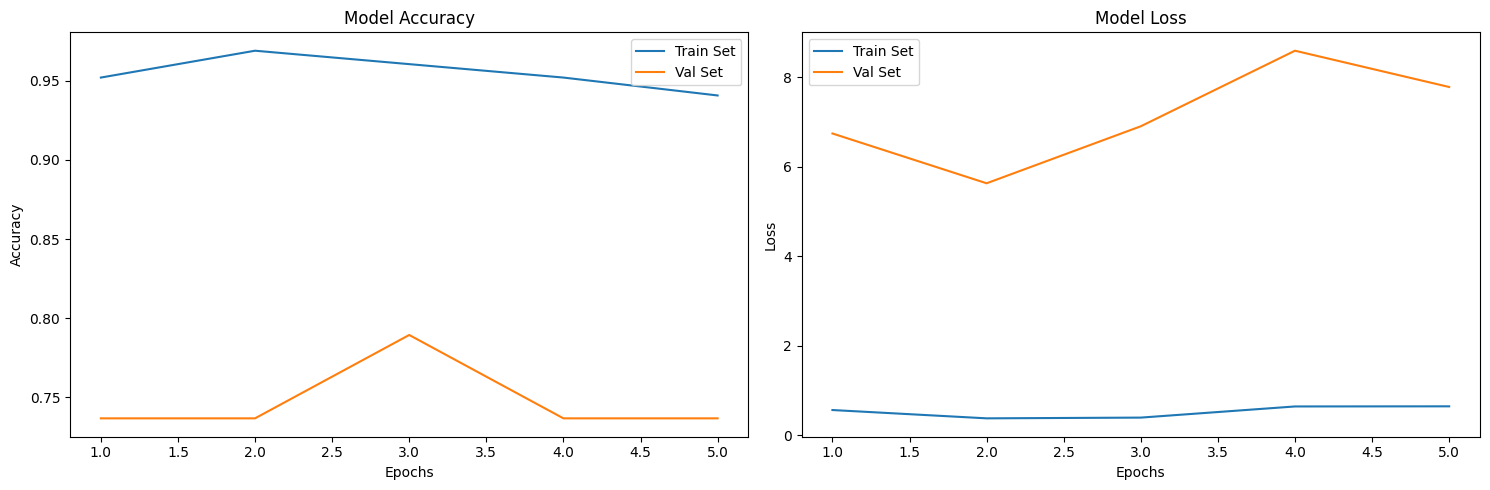

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# NEW
# validate on train set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % (accuracy * 100), '%')

12/12 [==============================] - 2s 189ms/step
Train Accuracy = 99.72 %


In [ ]:
# NEW
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 177ms/step
Val Accuracy = 73.68 %


In [ ]:
# NEW
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 177ms/step
Test Accuracy = 81.58 %


2/2 [==============================] - 0s 173ms/step


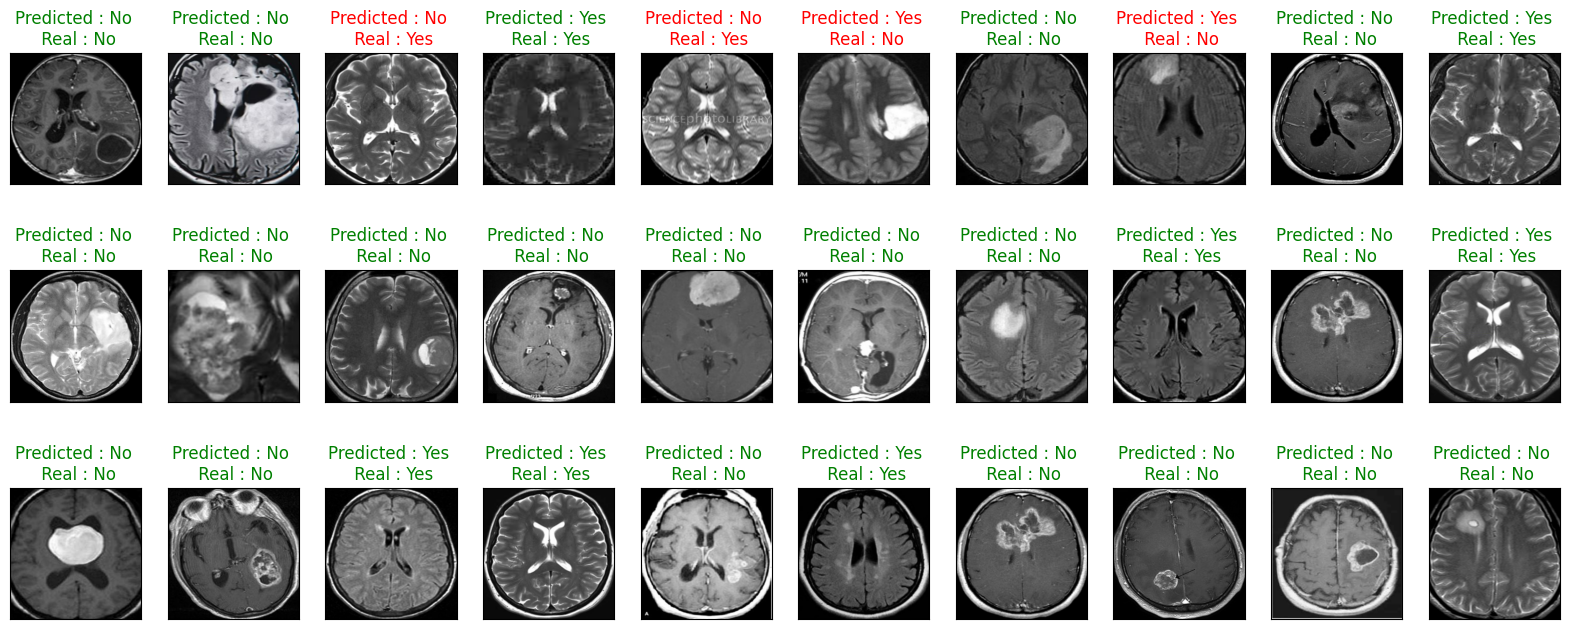

In [ ]:
y_hat = model.predict(X_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN_16_batch_20_epoch.h5')

BEGIN XGBOOST

In [ ]:
# Export feature from last CNN layer
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_val)
print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

12/12 [==============================] - 2s 188ms/step
(354, 1)
2/2 [==============================] - 0s 172ms/step
(38, 1)
2/2 [==============================] - 0s 171ms/step
(38, 1)


In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(objective='multi:softmax', learning_rate=0.1, max_depth=15, num_class=2)

xb.fit(feat_train,y_train)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(feat_train,y_train)

0.9971751412429378

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data training

# make predictions for train data
y_pred = xb.predict(feat_train)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.72%


In [ ]:
xb.score(feat_val,y_val)

0.7368421052631579

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data validation

# make predictions for val data
y_pred = xb.predict(feat_val)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.68%


Perbandingan akurasi model CNN dan CNN-XGBoost terhadap data testing


In [ ]:
# Akurasi model CNN-VGG19 terhadap data testing

# make predictions for test data
y_pred = model.predict(X_test)

predictions = [np.round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

2/2 [==============================] - 0s 174ms/step
Accuracy: 81.58%


In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data testing

# make predictions for test data
y_pred = xb.predict(feat_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.95%


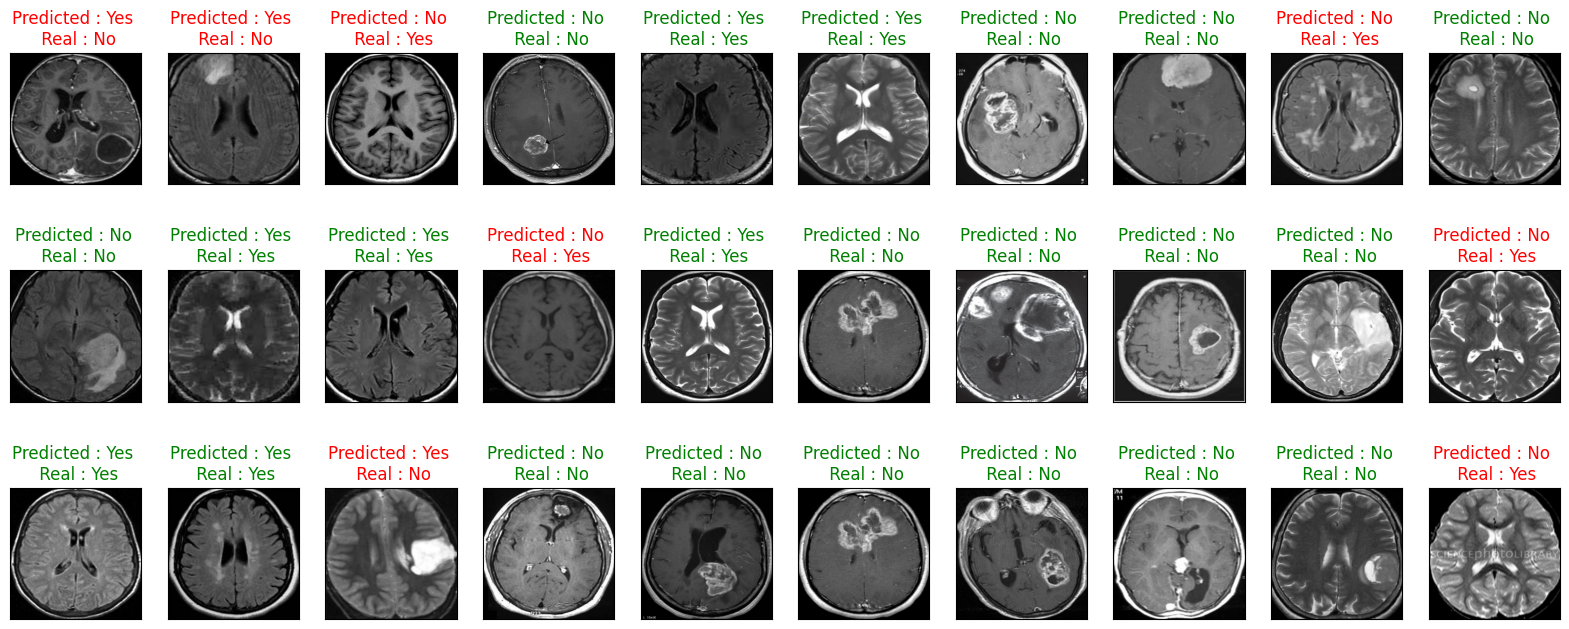

In [ ]:
# NEW
y_hat_xgb = xb.predict(feat_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(feat_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat_xgb[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN-XGBoost_16_batch_20_epoch.h5')

END XGBoost

25 EPOCH

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val),
    # callbacks=[es]
)

Epoch 1/5
23/23 [==============================] - 3s 108ms/step - loss: 0.8128 - accuracy: 0.9435 - val_loss: 7.2926 - val_accuracy: 0.8158
Epoch 2/5
23/23 [==============================] - 2s 105ms/step - loss: 0.5115 - accuracy: 0.9435 - val_loss: 8.0835 - val_accuracy: 0.7632
Epoch 3/5
23/23 [==============================] - 2s 109ms/step - loss: 0.6241 - accuracy: 0.9435 - val_loss: 9.2721 - val_accuracy: 0.7632
Epoch 4/5
23/23 [==============================] - 3s 110ms/step - loss: 0.3407 - accuracy: 0.9605 - val_loss: 7.9412 - val_accuracy: 0.7895
Epoch 5/5
23/23 [==============================] - 2s 106ms/step - loss: 0.6055 - accuracy: 0.9689 - val_loss: 7.2629 - val_accuracy: 0.7895


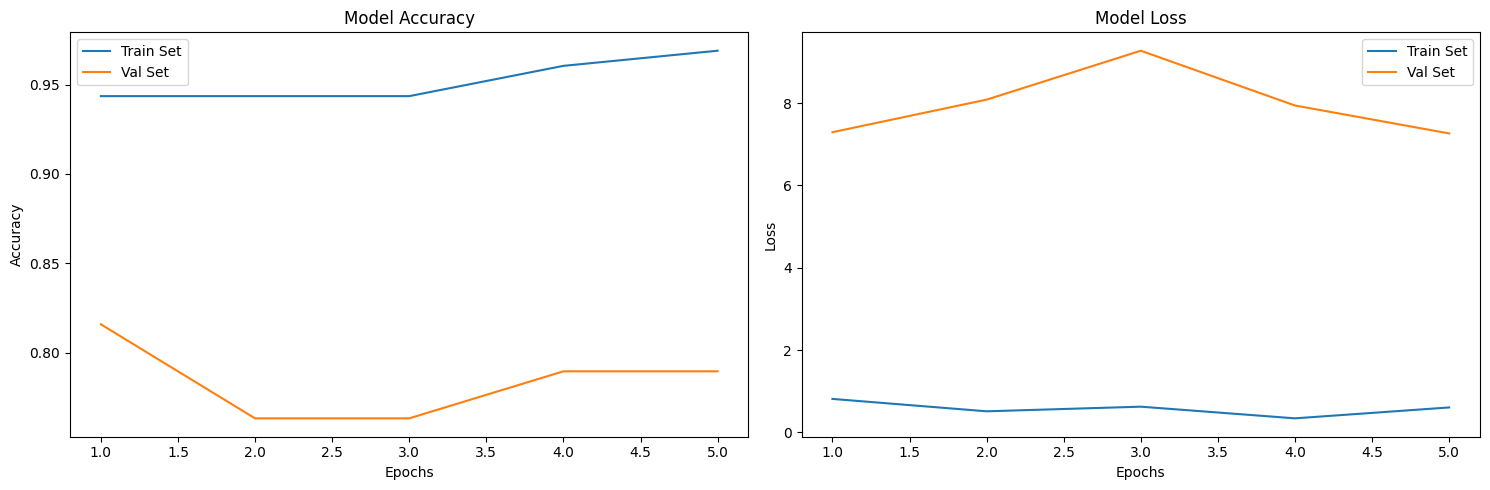

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# NEW
# validate on train set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % (accuracy * 100), '%')

12/12 [==============================] - 2s 190ms/step
Train Accuracy = 97.46 %


In [ ]:
# NEW
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 178ms/step
Val Accuracy = 78.95 %


In [ ]:
# NEW
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % (accuracy * 100), '%')

2/2 [==============================] - 0s 177ms/step
Test Accuracy = 81.58 %


2/2 [==============================] - 0s 176ms/step


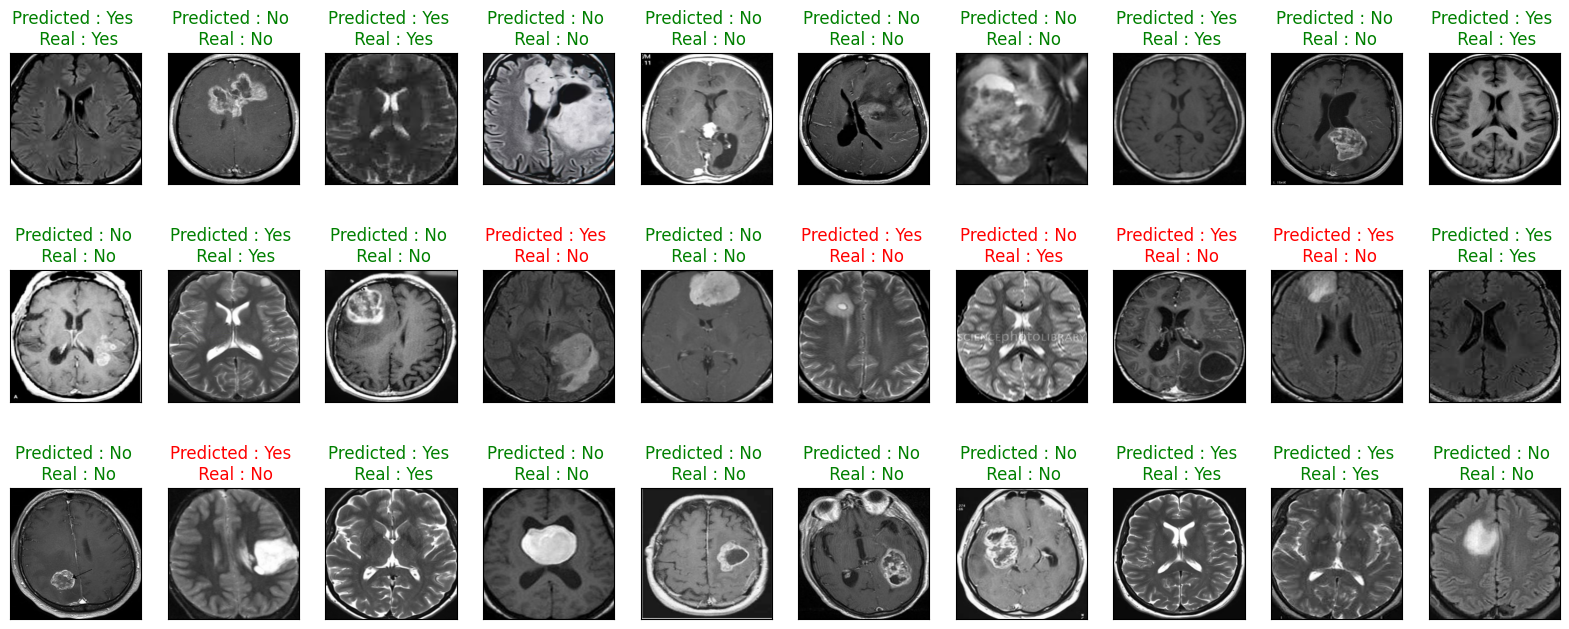

In [ ]:
y_hat = model.predict(X_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN_16_batch_25_epoch.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model/50_CycleGAN-CNN_16_batch_25_epoch.h5')

BEGIN XGBOOST

In [ ]:
# Export feature from last CNN layer
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_val)
print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

12/12 [==============================] - 12s 248ms/step
(354, 1)
2/2 [==============================] - 2s 2s/step
(38, 1)
2/2 [==============================] - 0s 160ms/step
(38, 1)


In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(objective='multi:softmax', learning_rate=0.1, max_depth=15, num_class=2)

xb.fit(feat_train,y_train)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(feat_train,y_train)

1.0

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data training

# make predictions for train data
y_pred = xb.predict(feat_train)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [ ]:
xb.score(feat_val,y_val)

0.7631578947368421

In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data validation

# make predictions for val data
y_pred = xb.predict(feat_val)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.32%


Perbandingan akurasi model CNN dan CNN-XGBoost terhadap data testing


In [ ]:
# Akurasi model CNN-VGG19 terhadap data testing

# make predictions for test data
y_pred = model.predict(X_test)

predictions = [np.round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

2/2 [==============================] - 1s 162ms/step
Accuracy: 81.58%


In [ ]:
# Akurasi model CNN-VGG19-XGBoost terhadap data testing

# make predictions for test data
y_pred = xb.predict(feat_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.47%


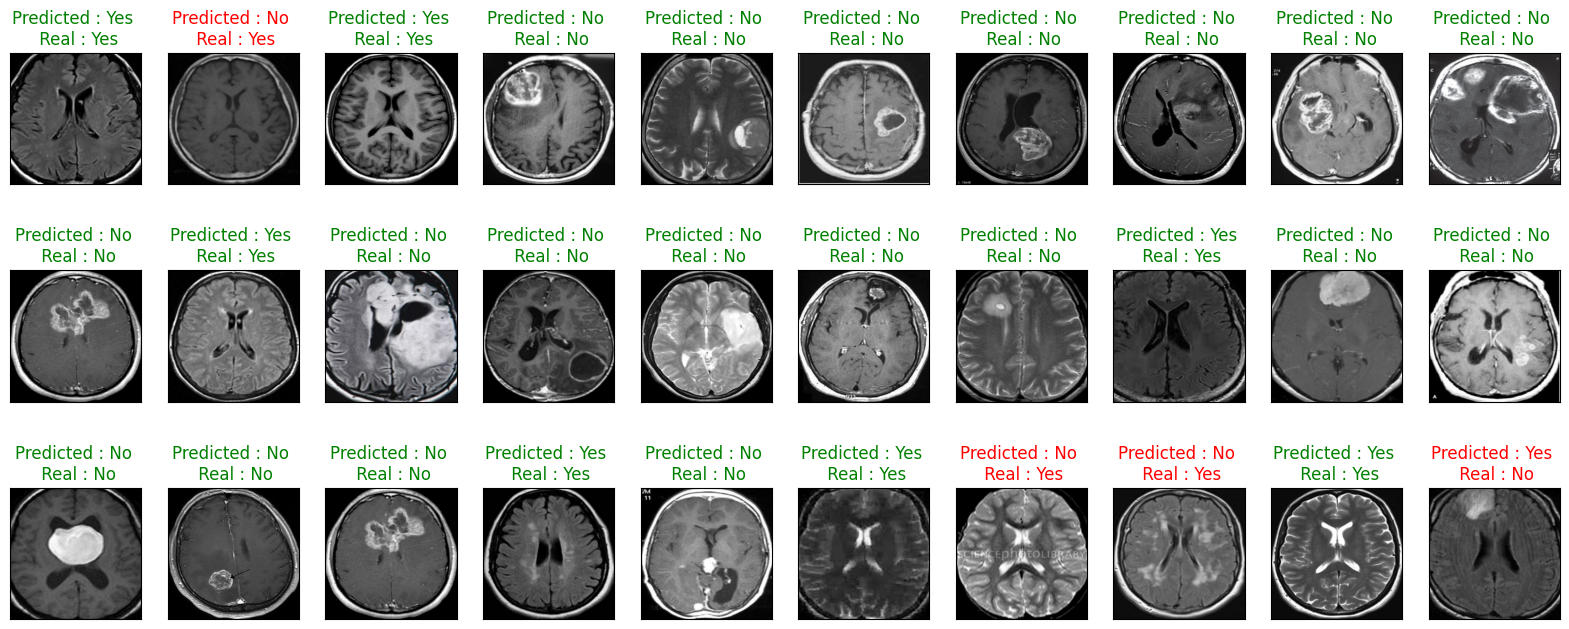

In [ ]:
# NEW
y_hat_xgb = xb.predict(feat_test)

labels =["Yes", "No"]

# Plot gambar test secara acak, hasil prediksi, dan label sebenarnya
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(feat_test.shape[0], size=30, replace=False)):
  ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])

  # Tampilkan gambar
  ax.imshow(np.squeeze(X_test[index]))
  if(y_hat_xgb[index] > 0.5):
    predict_index = 1
  else:
    predict_index = 0
  true_index = (y_test[index][0])

  # Judul tiap gambar
  ax.set_title("Predicted : {} \n Real : {}".format(labels[predict_index], labels[true_index]),
               color=("green" if predict_index == true_index else "red"))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Model/50_CycleGAN-CNN-XGBoost_16_batch_25_epoch.h5')

In [ ]:
xb.save_model('/content/drive/MyDrive/Model/test_50_CycleGAN-CNN-XGBoost_16_batch_25_epoch.json')

In [ ]:
loaded_xgb = XGBClassifier()
loaded_xgb.load_model('/content/drive/MyDrive/Model/test_50_CycleGAN-CNN-XGBoost_16_batch_25_epoch.json')

END XGBoost

In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    if print_res == 1:
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = 2 * (precision * recall) / (precision + recall)

        print('Accuracy =     {:.3f}'.format(accuracy))
        print('F1-Score =     {:.3f}'.format(f1))
        print('Precision =     {:.3f}'.format(precision))
        print('Recall (TPR) =  {:.3f}'.format(recall))
        # print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

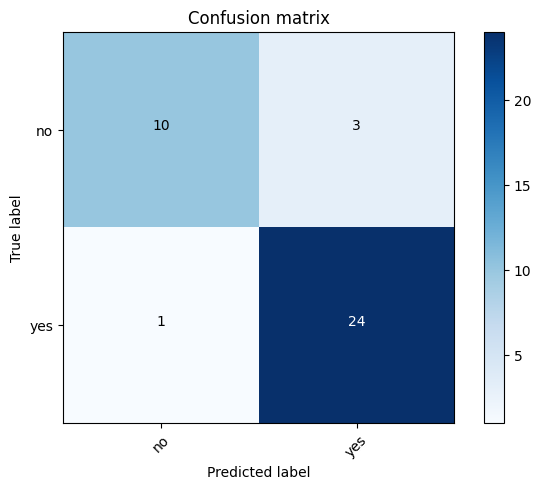

Accuracy =     0.895
F1-Score =     0.923
Precision =     0.889
Recall (TPR) =  0.960


In [ ]:
y_pred = loaded_xgb.predict(feat_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['no', 'yes'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

Validation

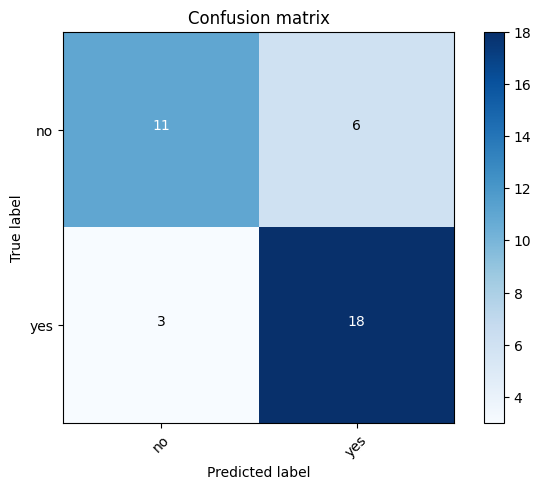

Accuracy =     0.763
F1-Score =     0.800
Precision =     0.750
Recall (TPR) =  0.857


In [ ]:
y_pred = loaded_xgb.predict(feat_val)
thresh = 0.5
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm, ['no', 'yes'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

Train

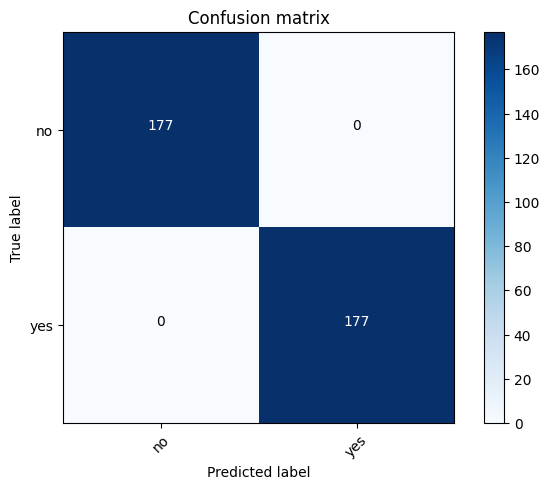

Accuracy =     1.000
F1-Score =     1.000
Precision =     1.000
Recall (TPR) =  1.000


In [ ]:
y_pred = loaded_xgb.predict(feat_train)
thresh = 0.5
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(cm, ['no', 'yes'], )
pr, tpr, fpr = show_data(cm, print_res = 1);